# Testing
## Bevölkerung nach Monat, Stadtquartier, Geschlecht, Altersgruppe und Herkunft, seit 1998
Datum: 08.12.2021

### Importiere die notwendigen Packages

In [43]:
import pandas as pd
import pivottablejs
from pivottablejs import pivot_ui
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
#from datetime import datetime
import datetime
import geopandas as gpd
import folium 


Definiere Settings. Hier das Zahlenformat von Float-Werten (z.B. *'{:,.2f}'.format* mit Komma als Tausenderzeichen), 

In [44]:
pd.options.display.float_format = '{:.0f}'.format
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 15)

### Zeitvariabeln
Bestimme den aktuellst geladenen Monat. Hier ist es der Stand vor 2 Monaten. 
Bestimme noch weitere evt. sinnvolle Zeitvariabeln.

Zum Unterschied zwischen import datetime und from datedtime import datetime, siehe https://stackoverflow.com/questions/15707532/import-datetime-v-s-from-datetime-import-datetime

Zuerst die Zeitvariabeln als Strings

In [45]:
#today_date = datetime.date.today()
#date_time = datetime.datetime.strptime(date_time_string, '%Y-%m-%d %H:%M')
now = datetime.date.today()
date_today = now.strftime("%Y-%m-%d")
year_today = now.strftime("%Y")
month_today = now.strftime("%m")
day_today = now.strftime("%d")



Und hier noch die Zeitvariabeln als Integers:
- `aktuellesJahr`
- `aktuellerMonat`: Der gerade jetzt aktuelle Monat
- `selectedMonat`: Der aktuellste Monat in den Daten. In der Regel zwei Monate her.

In [46]:
#now = datetime.now() 
int_times = now.timetuple()

aktuellesJahr = int_times[0]
aktuellerMonat = int_times[1]
selectedMonat = int_times[1]-2

print(aktuellesJahr, 
      aktuellerMonat,
    'datenstand: ', selectedMonat,
     int_times)


2021 12 datenstand:  10 time.struct_time(tm_year=2021, tm_mon=12, tm_mday=17, tm_hour=0, tm_min=0, tm_sec=0, tm_wday=4, tm_yday=351, tm_isdst=-1)


Berechne die Variable Epoche um später das SAS-Datum in ein Unix-Datum umzuwandeln. Bei SAS beginnt die Epoche am 1.1.1960. Bei Unix am 1.1.1970.
Diese Variable wird beim CSV-Import benötigt.

In [47]:
epoch = datetime.datetime(1960, 1, 1)

### Importiere einen Datensatz 

- Beachte dabei die Notation des Pfades...
- Definiere mal aktuell noch keine weiteren Parameter beim Import

**Dataset auf INTEG Datenkatalog**:  https://data.integ.stadt-zuerich.ch/dataset/int_dwh_bev_monat_bestand_quartier_geschl_ag_herkunft_od3250

**Dataset auf PROD Datenkatalog**:  https://data.stadt-zuerich.ch/dataset/bev_monat_bestand_quartier_geschl_ag_herkunft_od3250

In [48]:
#Die Datasets sind nur zum Testen auf INT-DWH-Dropzone. Wenn der Test vorbei ist, sind sie auf PROD. 
# Über den Status kann man einfach switchen

status = "prod";
print(status)

prod


In [52]:
# Filepath
if status == "prod":
    #fp = r"//szh.loc/ssz/applikationen/OGD_Dropzone/DWH/bev_monat_bestand_quartier_geschl_ag_herkunft_od3250/BEV325OD3250.csv"
    fp = r"https://data.stadt-zuerich.ch/dataset/bev_monat_bestand_quartier_geschl_ag_herkunft_od3250/download/BEV325OD3250.csv"
else:
    #fp = r"//szh.loc/ssz/applikationen/OGD_Dropzone/INT_DWH/bev_monat_bestand_quartier_geschl_ag_herkunft_od3250/BEV325OD3250.csv"
    fp = r"https://data.integ.stadt-zuerich.ch/dataset/int_dwh_bev_monat_bestand_quartier_geschl_ag_herkunft_od3250/download/BEV325OD3250.csv"


print(fp)

https://data.stadt-zuerich.ch/dataset/bev_monat_bestand_quartier_geschl_ag_herkunft_od3250/download/BEV325OD3250.csv


Beachte, wie das SAS Datum (ohne Format) in ein UNIX Datum umgerechnet und als Datumsformat dargestellt wird! Siehe dazu `https://stackoverflow.com/questions/26923564/convert-sas-numeric-to-python-datetime`

In [53]:
# Read the data
data2betested = pd.read_csv(
    fp, 
    sep=',',
    parse_dates=['StichtagDat'],
    # KONVERTIERE DAS SAS DATUM IN EIN UNIXDATUM UND FORMATIERE ES
    date_parser=lambda s: epoch + datetime.timedelta(days=int(s)),
    low_memory=False    
    )

print('done')

done


In der Folge ein paar erste Tests:

 - 1) Zeige eine kurze Vorschau der importierten Daten
 - 2) Weise die Datentypen aus
 - 3) Zeige die Shape (Umfang) des Datensatzes an

In [54]:
data2betested.sort_values(by=['StichtagDatJahr','StichtagDatMM'], ascending=False).head(3)

,StichtagDatJahr,StichtagDatMM,StichtagDatMonat,StichtagDat,SexCd,SexLang,AlterV20Sort,...,KreisCd,KreisLang,QuarCd,QuarLang,DatenstandCd,DatenstandLang,AnzBestWir
193499,2021,10,Oktober,2021-10-31,1,männlich,1,...,1,Kreis 1,11,Rathaus,P,Provisorisch,119
193500,2021,10,Oktober,2021-10-31,1,männlich,1,...,1,Kreis 1,12,Hochschulen,P,Provisorisch,28
193501,2021,10,Oktober,2021-10-31,1,männlich,1,...,1,Kreis 1,13,Lindenhof,P,Provisorisch,40


In [55]:
data2betested.dtypes

StichtagDatJahr              int64
StichtagDatMM                int64
StichtagDatMonat            object
StichtagDat         datetime64[ns]
SexCd                        int64
SexLang                     object
AlterV20Sort                 int64
AlterV20Kurz                object
HerkunftCd                   int64
HerkunftLang                object
KreisCd                      int64
KreisLang                   object
QuarCd                       int64
QuarLang                    object
DatenstandCd                object
DatenstandLang              object
AnzBestWir                   int64
dtype: object

In [56]:
data2betested.shape

(194192, 17)

Beschreibe einzelne Attribute

In [57]:
data2betested.describe()

,StichtagDatJahr,StichtagDatMM,SexCd,AlterV20Sort,HerkunftCd,KreisCd,QuarCd,AnzBestWir
count,194192,194192,194192,194192,194192,194192,194192,194192
mean,2009,6,2,3,1,6,66,573
std,7,3,1,1,0,5,43,614
min,1998,1,1,1,1,1,11,0
25%,2003,3,1,2,1,3,33,104
50%,2009,6,2,3,1,7,71,377
75%,2015,9,2,4,2,9,92,822
max,2021,12,2,5,2,99,999,3737


Wie viele Nullwerte gibt es im Datensatz?

In [58]:
data2betested.isnull().sum()

StichtagDatJahr     0
StichtagDatMM       0
StichtagDatMonat    0
StichtagDat         0
SexCd               0
SexLang             0
AlterV20Sort        0
AlterV20Kurz        0
HerkunftCd          0
HerkunftLang        0
KreisCd             0
KreisLang           0
QuarCd              0
QuarLang            0
DatenstandCd        0
DatenstandLang      0
AnzBestWir          0
dtype: int64

### Verwende das Datum als Index

While we did already parse the `datetime` column into the respective datetime type, it currently is just a regular column. 
**To enable quick and convenient queries and aggregations, we need to turn it into the index of the DataFrame**

In [59]:
data2betested = data2betested.set_index("StichtagDat")
#data2betested = data2betested.drop(columns=["StichtagDatMM"])

In [60]:
data2betested.info()
data2betested.index.day.unique()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 194192 entries, 1998-01-31 to 2021-10-31
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   StichtagDatJahr   194192 non-null  int64 
 1   StichtagDatMM     194192 non-null  int64 
 2   StichtagDatMonat  194192 non-null  object
 3   SexCd             194192 non-null  int64 
 4   SexLang           194192 non-null  object
 5   AlterV20Sort      194192 non-null  int64 
 6   AlterV20Kurz      194192 non-null  object
 7   HerkunftCd        194192 non-null  int64 
 8   HerkunftLang      194192 non-null  object
 9   KreisCd           194192 non-null  int64 
 10  KreisLang         194192 non-null  object
 11  QuarCd            194192 non-null  int64 
 12  QuarLang          194192 non-null  object
 13  DatenstandCd      194192 non-null  object
 14  DatenstandLang    194192 non-null  object
 15  AnzBestWir        194192 non-null  int64 
dtypes: int64(8), object(8)

Int64Index([31, 28, 30, 29], dtype='int64', name='StichtagDat')

### Einfache Visualisierungen zur Plausi

Exploriere die Daten mit Pivottable.JS

In [61]:
from pivottablejs import pivot_ui

pivot_ui(data2betested)

### Zeitpunkte und Zeiträume abfragen

A particular powerful feature of the Pandas DataFrame is its indexing capability that also works using time-based entities, such as dates and times. We have already created the index above, so let's put it to use.

In [62]:
data2betested.loc["2017-06-30"]
data2betested.loc["2017-10-04":"2017-12-06"].head(2)

,StichtagDatJahr,StichtagDatMM,StichtagDatMonat,SexCd,SexLang,AlterV20Sort,AlterV20Kurz,...,KreisCd,KreisLang,QuarCd,QuarLang,DatenstandCd,DatenstandLang,AnzBestWir
StichtagDat,,,,,,,,,,,,,,,
2017-10-31,2017,10,Oktober,1,männlich,1,0-19,...,1,Kreis 1,11,Rathaus,V,Veröffentlicht,118
2017-10-31,2017,10,Oktober,1,männlich,1,0-19,...,1,Kreis 1,12,Hochschulen,V,Veröffentlicht,24


### Aggriere Werte nach Zeitausschnitten

Mit den Funktionen zur Zeit kann einfach zwischen Stunden, Tagen, Monaten, etc. gewechselt und aggregiert werden.


In [63]:
bsp_sums = data2betested.resample("Y").sum().head()
bsp_sums

,StichtagDatJahr,StichtagDatMM,SexCd,AlterV20Sort,HerkunftCd,KreisCd,QuarCd,AnzBestWir
StichtagDat,,,,,,,,
1998-12-31,16277706,52951,12227,24415,12214,50865,528520,4317059
1999-12-31,16245873,52796,12207,24315,12174,50815,527970,4332505
2000-12-31,16244000,52812,12202,24290,12164,50818,527990,4335735
2001-12-31,16256124,52807,12203,24300,12168,50832,528133,4352517
2002-12-31,16232216,52736,12177,24220,12136,50817,527939,4368608


In [64]:
# first we create the sums per week
weekly_sums = data2betested.resample("W").sum()
# then we generate the weekly means for each quarter
data2betested_sel = data2betested[["SexCd","HerkunftCd","AnzBestWir"]]
quarterly_sums = data2betested_sel.resample("Q").sum()
# for readability we'll revert the values back to integers
quarterly_sums.astype(int).head(2)

,SexCd,HerkunftCd,AnzBestWir
StichtagDat,,,
1998-03-31,3057,3054,1077987
1998-06-30,3057,3054,1080544


### Visualisierungen nach Zeitausschnitten

In [84]:
#data2betested.info()


Liniendiagramm 
[Link zur Doku](https://altair-viz.github.io/gallery/multiline_highlight.html)

### Selektionen und Aggregationen

Check this [Doku](https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/)

Wähle einen Datenbereich aus zum Visualsieren

In [86]:
myTimeSelection = data2betested[(data2betested.StichtagDatJahr>aktuellesJahr-1) & (data2betested.StichtagDatMM == selectedMonat)]
myTimeSelection

,StichtagDatJahr,StichtagDatMM,StichtagDatMonat,SexCd,SexLang,AlterV20Sort,AlterV20Kurz,...,KreisCd,KreisLang,QuarCd,QuarLang,DatenstandCd,DatenstandLang,AnzBestWir
StichtagDat,,,,,,,,,,,,,,,
2021-10-31,2021,10,Oktober,1,männlich,1,0-19,...,1,Kreis 1,11,Rathaus,P,Provisorisch,119
2021-10-31,2021,10,Oktober,1,männlich,1,0-19,...,1,Kreis 1,12,Hochschulen,P,Provisorisch,28
2021-10-31,2021,10,Oktober,1,männlich,1,0-19,...,1,Kreis 1,13,Lindenhof,P,Provisorisch,40
2021-10-31,2021,10,Oktober,1,männlich,1,0-19,...,1,Kreis 1,14,City,P,Provisorisch,53
2021-10-31,2021,10,Oktober,1,männlich,1,0-19,...,2,Kreis 2,21,Wollishofen,P,Provisorisch,1514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-31,2021,10,Oktober,2,weiblich,5,80 u. älter,...,11,Kreis 11,115,Oerlikon,P,Provisorisch,72
2021-10-31,2021,10,Oktober,2,weiblich,5,80 u. älter,...,11,Kreis 11,119,Seebach,P,Provisorisch,86
2021-10-31,2021,10,Oktober,2,weiblich,5,80 u. älter,...,12,Kreis 12,121,Saatlen,P,Provisorisch,19


In [87]:
#data2betested.dtypes

In [88]:
mySelection = myTimeSelection.groupby(
    ['AlterV20Sort','AlterV20Kurz','KreisCd','KreisLang','StichtagDatMM', 'StichtagDatMonat','StichtagDatJahr']
#  ['StichtagDatJahr','StichtagDatMM', 'StichtagDatMonat','AlterV20Sort','AlterV20Kurz']    
).agg(
    {
        #'StichtagDatJahr': 'first',
        #'AlterV20Kurz': 'first',
        'AnzBestWir':'sum',
    }
)
mySelection



AnzBestWir
AlterV20Sort AlterV20Kurz KreisCd KreisLang StichtagDatMM StichtagDatMonat StichtagDatJahr            
1            0-19         1       Kreis 1   10            Oktober          2021                    571
                          2       Kreis 2   10            Oktober          2021                   7257
                          3       Kreis 3   10            Oktober          2021                   8991
                          4       Kreis 4   10            Oktober          2021                   3176
                          5       Kreis 5   10            Oktober          2021                   2038
...                                                                                                ...
5            80 u. älter  9       Kreis 9   10            Oktober          2021                   2999
                          10      Kreis 10  10            Oktober          2021                   2343
                          11      Kreis 11  10            Oktober          2021                   3157
                          12      Kreis 12  10            Oktober          2021                   1500
                          99      Unbekannt 10            Oktober          2021                      2

[65 rows x 1 columns]

In [89]:
mySelection.dtypes

AnzBestWir    int64
dtype: object

In [109]:
myGraph = data2betested[(data2betested.StichtagDatJahr > aktuellesJahr-1)&(data2betested.StichtagDatMM > selectedMonat-1)&(data2betested.AlterV20Kurz != '80 u. älter')]

In [113]:
agg_myGraph = myGraph.groupby(
   ['QuarCd','QuarLang', 'AlterV20Kurz']
).agg(
    {
         #'AnzBestWir': (sum, min, max)
        'AnzBestWir': (sum)
    }
)
#agg_myGraph.melt()
agg_myGraph


AnzBestWir
QuarCd QuarLang    AlterV20Kurz            
11     Rathaus     0-19                 283
                   20-39               1308
                   40-59                901
                   60-79                669
12     Hochschulen 0-19                  70
...                                     ...
123    Hirzenbach  40-59               3268
                   60-79               1838
999    Unbekannt   20-39                  1
                   40-59                  2
                   60-79                  3

[139 rows x 1 columns]

In [111]:
# df_statzonen = df_statzonen[(df_statzonen.knr>0) & (df_statzonen.qname!="Hirslanden")]
#aktuellesJahr[[aktuellesJahr.KreisSort =7]])
highlight = alt.selection(type='single', on='mouseover',
                          fields=['AlterV20Kurz'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(agg_myGraph).encode(
    x='AlterV20Kurz',
    y='AnzBestWir',
    color='QuarLang'
)

points = base.mark_circle().encode(
    opacity=alt.value(0)
).add_selection(
    highlight
).properties(
    width=700 , height=300
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(1.5), alt.value(4))
).interactive()

points + lines

ValueError: Hierarchical indices not supported

alt.LayerChart(...)

In [69]:
alt.Chart(mySelection).mark_circle(size=60).encode(
    x='StichtagDatJahr',
    y='AlterV20Kurz',
    #color='AnzNat',
    #color=alt.Color('AnzNat', scale=alt.Scale(scheme='dark2')),
    color=alt.Color('AlterV20Kurz', scale=alt.Scale(scheme='greens')),
    tooltip=['StichtagDatJahr','AlterV20Kurz','AnzBestWir']
).interactive() # this makes the axes interactive: now you can zoom & pan




ValueError: Hierarchical indices not supported

alt.Chart(...)

**Test: Choroplethenkarte**
Importiere die Geodaten als GeoJSON

In [24]:
# Read abt. Geopandas https://geopandas.org/docs/user_guide/io.html
# Wenn die Daten lokal agelegt sind, dann kannst Du folgendes machen:
##input_stadtquartiere = r"//szh.loc/ssz/data/GIS/Daten/Vektor/_aktuell/stzh.adm_statistische_quartiere_map.json"
##df_stadtquartiere = gpd.read_file(input_stadtquartiere)
##df_stadtquartiere.head(2)
#df_stadtkreise.dtypes

geojson_url = "https://www.ogd.stadt-zuerich.ch/wfs/geoportal/Statistische_Quartiere?service=WFS&version=1.1.0&request=GetFeature&outputFormat=GeoJSON&typename=adm_statistische_quartiere_map"
df_adm_statistische_quartiere_map = gpd.read_file(geojson_url)

df_adm_statistische_quartiere_map.head(5)


,id,kname,knr,objectid,objid,qname,qnr,geometry
0,adm_statistische_quartiere_map.1,Kreis 7,7,1,34,Hirslanden,73,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ..."
1,adm_statistische_quartiere_map.2,Kreis 8,8,2,33,Weinegg,83,"POLYGON ((8.55670 47.36405, 8.55672 47.36403, ..."
2,adm_statistische_quartiere_map.3,Kreis 8,8,3,32,Mühlebach,82,"POLYGON ((8.55423 47.36456, 8.55426 47.36452, ..."
3,adm_statistische_quartiere_map.4,Kreis 8,8,4,31,Seefeld,81,"POLYGON ((8.54795 47.36500, 8.54805 47.36489, ..."
4,adm_statistische_quartiere_map.7,Kreis 4,4,7,16,Werd,41,"POLYGON ((8.53300 47.37394, 8.53299 47.37392, ..."


Joine die importierten statistischen Daten des aktuellen Jahres zum Geodatensatz:

*Siehe dazu Doku zu [Geopandas](https://geopandas.org/docs/user_guide/mergingdata.html)*

In [25]:
myGraph = myTimeSelection.groupby(
    ['StichtagDatJahr','StichtagDatMM','QuarCd','QuarLang']
).agg(

    {
        'AnzBestWir':'sum',
    }
)
myGraph.head()


#myTimeSelection



AnzBestWir
StichtagDatJahr StichtagDatMM QuarCd QuarLang               
2021            7             11     Rathaus            3238
                              12     Hochschulen         677
                              13     Lindenhof          1020
                              14     City                818
                              21     Wollishofen       20020

In [26]:
stats_agg_quartiere = myGraph.groupby(['StichtagDatJahr', 'QuarCd','QuarLang'])[['AnzBestWir']].sum()
#stats_agg_quartiere=aktuellesJahr.groupby(['Jahr', 'QuarSort'])['AnzWhg','Wohnungsfl', 'PersInGeb'].sum()
#test = data2betested.groupby(['StichtagDatJahr', 'AlterV20Kurz'])[['AnzBestWir']].agg()
#stats_agg_quartiere.head()
stats_agg_quartiere.head(3)

AnzBestWir
StichtagDatJahr QuarCd QuarLang               
2021            11     Rathaus            3238
                12     Hochschulen         677
                13     Lindenhof          1020

In [27]:
# Rename attribute stznr to StatZoneSort, so the IDs have the same name

stadtquartiere_shapes = df_adm_statistische_quartiere_map[['geometry', 'qnr', 'qname', 'knr']].rename(columns={'qnr': 'QuarCd'})

# Merge with `merge` method on shared variable (stznr und StatZoneSort):
stadtquartiere_shapes_joined = stadtquartiere_shapes.merge(stats_agg_quartiere, on='QuarCd')

stadtquartiere_shapes_joined.head(13)


,geometry,QuarCd,qname,knr,AnzBestWir
0,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ...",73,Hirslanden,7,7396
1,"POLYGON ((8.55670 47.36405, 8.55672 47.36403, ...",83,Weinegg,8,5540
2,"POLYGON ((8.55423 47.36456, 8.55426 47.36452, ...",82,Mühlebach,8,6404
3,"POLYGON ((8.54795 47.36500, 8.54805 47.36489, ...",81,Seefeld,8,5811
4,"POLYGON ((8.53300 47.37394, 8.53299 47.37392, ...",41,Werd,4,4603
5,"POLYGON ((8.51937 47.37478, 8.51946 47.37465, ...",34,Sihlfeld,3,21580
6,"POLYGON ((8.50127 47.37961, 8.50121 47.37957, ...",91,Albisrieden,9,22236
7,"POLYGON ((8.58346 47.38831, 8.58418 47.38833, ...",72,Hottingen,7,11213
8,"POLYGON ((8.54297 47.33543, 8.54285 47.33537, ...",21,Wollishofen,2,20020
9,"POLYGON ((8.52688 47.40709, 8.52687 47.40711, ...",61,Unterstrass,6,24368


<AxesSubplot:>

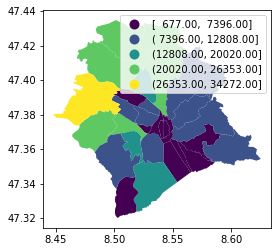

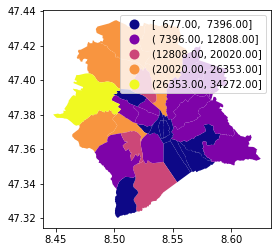

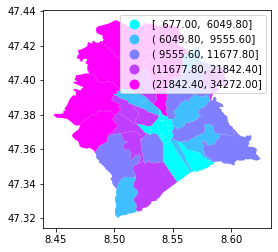

In [28]:
# Plot by StatQuartiere
# Weitere Schemes: scheme='quantiles', scheme='fisherjenks', scheme='natural_breaks',

stadtquartiere_shapes_joined.plot(column='AnzBestWir', cmap='viridis', scheme='natural_breaks', legend=True )
#scheme werte: https://matplotlib.org/2.0.2/users/colormaps.html

stadtquartiere_shapes_joined.plot(column='AnzBestWir', cmap='plasma', scheme='fisherjenks', legend=True )
#scheme werte: https://matplotlib.org/2.0.2/users/colormaps.html
stadtquartiere_shapes_joined.plot(column='AnzBestWir', cmap='cool', scheme='quantiles', legend=True )
#scheme werte: https://matplotlib.org/2.0.2/users/colormaps.html

#
#Neuere Gallerie: https://matplotlib.org/stable/gallery/index.html

Noch zu prüfen, folgendes schöne Beispiel: https://docs.bokeh.org/en/latest/docs/user_guide/interaction/legends.html

Konkrete Beispiele von Bookeh in Jupyter NB: https://docs.bokeh.org/en/latest/docs/user_guide/jupyter.html

**Sharepoint als gecheckt markieren!**

Record auf Sharepoint: **[Link](http://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/EditForm.aspx?ID=157&Source=%2Forga%2Fssz%2Dprodukte%2FLists%2FSASA%5FOutputs)**